In [14]:
%pip install pandas geopy openpyxl plotly geopandas matplotlib


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/51.5 kB ? eta -:--:--
     ---------------------------------------- 51.5/51.5 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/165.5 kB ? eta -:--:--
     -------------------------------------  163.8/165.5 kB 4.8 MB/s eta 0:00:01
     -------------------------------------- 165.5/165.5 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   -------- ------------------------------- 0.2/1.1 MB 7.3 MB/s eta 0:00:01
   -------- ------------------------------- 0.2/1.1 MB 7.3 MB/s eta 0:00:01
   ---------------- ----------------------- 0.5/1.1 MB 3.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.6/1.1 MB 3.3 MB/s eta 0:00:01
   ------------------------- -------------- 0.7/1.1 MB 2.9 MB/s eta 0:00:01
   --------------------------------- ------ 0.9/1.1 MB 3.5 MB/s eta 0:00:01
   ---------

In [4]:
import pandas as pd
import csv
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.poolmanager import PoolManager
import ssl

class SSLAdapter(HTTPAdapter):
    def init_poolmanager(self, connections, maxsize, block=False):
        self.poolmanager = PoolManager(
            num_pools=connections, maxsize=maxsize,
            block=block, ssl_version=ssl.PROTOCOL_TLS)

# Function to read Excel file and extract unique countries
def get_unique_countries_from_excel(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Extract unique countries from Origin and Destination
    origin_countries = df['Origin Country'].dropna().unique()
    destination_countries = df['Destination Country'].dropna().unique()
    
    # Combine and get unique countries
    unique_countries = set(origin_countries).union(set(destination_countries))
    
    return unique_countries

# Function to get coordinates for a list of countries using OpenCage
def get_country_coordinates(countries, api_key):
    base_url = 'https://api.opencagedata.com/geocode/v1/json'
    country_coordinates = []

    # Create a session
    session = requests.Session()
    session.mount('https://', SSLAdapter())

    for country in countries:
        params = {
            'q': country,
            'key': api_key,
            'limit': 1
        }
        response = session.get(base_url, params=params, verify=False)
        data = response.json()
        if data['results']:
            location = data['results'][0]['geometry']
            country_coordinates.append([country, location['lat'], location['lng']])
    
    return country_coordinates

# Function to write coordinates to CSV
def write_coordinates_to_csv(country_coordinates, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Country', 'Latitude', 'Longitude'])
        writer.writerows(country_coordinates)
    print(f"Coordinates of countries have been written to {output_file}")

# Main function
def main(file_path, api_key):
    unique_countries = get_unique_countries_from_excel(file_path)
    country_coordinates = get_country_coordinates(unique_countries, api_key)
    output_file = 'country_coordinates.csv'
    write_coordinates_to_csv(country_coordinates, output_file)

# Example usage
if __name__ == "__main__":
    # Replace 'input_data.xlsx' with the path to your Excel file
    file_path = 'input_data.xlsx'

    api_key = 'dda431edacbc4fc5bf72fd503abb84c0'
    main(file_path, api_key)


C:\Users\wsealho\AppData\Roaming\Python\Python312\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.opencagedata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\wsealho\AppData\Roaming\Python\Python312\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.opencagedata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\wsealho\AppData\Roaming\Python\Python312\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.opencagedata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnin

Coordinates of countries have been written to country_coordinates.csv


In [11]:
import pandas as pd
import folium

# Function to read coordinates from CSV
def get_coordinates_dict(csv_path):
    coordinates_df = pd.read_csv(csv_path)
    coordinates_dict = {}
    for _, row in coordinates_df.iterrows():
        coordinates_dict[row['Country']] = (row['Latitude'], row['Longitude'])
    return coordinates_dict

# Function to create a folium map with transport routes
def create_transport_map(df, coordinates_dict):
    # Create a base map
    transport_map = folium.Map(location=[20, 0], zoom_start=2)

    # Define colors for transport modes
    mode_colors = {
        'SEA': 'blue',
        'AIR': 'red',
        'ROA': 'green',
        'RAIL': 'purple'
    }

    for index, row in df.iterrows():
        origin = row['Origin Country']
        destination = row['Destination Country']
        transport_mode = row['Transport Mode']
        actual_weight = row['Actual Weight (kg)']

        if pd.isna(origin) or pd.isna(destination):
            continue

        origin_coords = coordinates_dict.get(origin)
        destination_coords = coordinates_dict.get(destination)

        if not origin_coords or not destination_coords:
            continue

        folium.PolyLine(
            locations=[origin_coords, destination_coords],
            color=mode_colors.get(transport_mode, 'black'),
            weight=0.4 + actual_weight / 10000000000000000,
            opacity=0.2,
            popup=f"{transport_mode}: {actual_weight} kg"
        ).add_to(transport_map)

    # Save map to an HTML file
    transport_map.save('transport_map.html')
    print("Map has been created and saved as 'transport_map.html'")

# Main function
def main(excel_file_path, coordinates_csv_path):
    df = pd.read_excel(excel_file_path)
    coordinates_dict = get_coordinates_dict(coordinates_csv_path)
    create_transport_map(df, coordinates_dict)

# Example usage
if __name__ == "__main__":
    # Replace 'input_data.xlsx' with the path to your Excel file
    excel_file_path = 'input_data.xlsx'
    # Replace 'country_coordinates.csv' with the path to your CSV file with coordinates
    coordinates_csv_path = 'country_coordinates.csv'
    main(excel_file_path, coordinates_csv_path)


Map has been created and saved as 'transport_map.html'


C:\Users\wsealho\AppData\Local\Temp\ipykernel_3860\4037055279.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


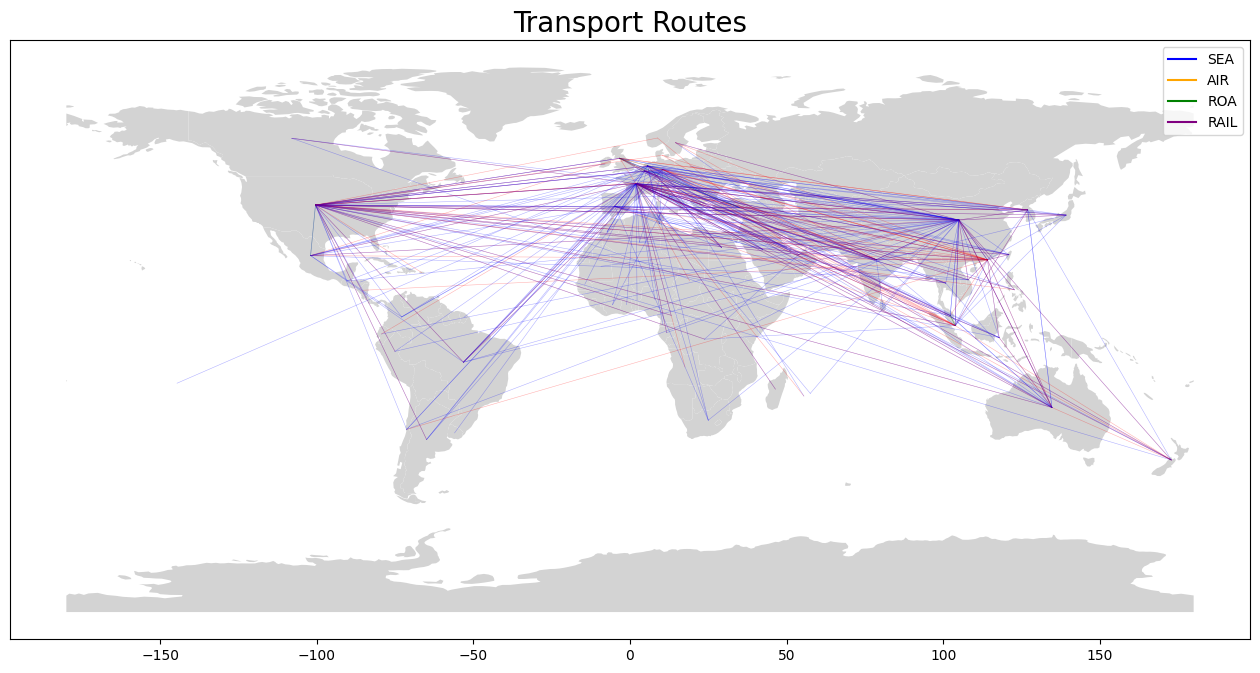

Map has been created and saved as 'transport_map.png'


: 

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Function to read coordinates from CSV
def get_coordinates_dict(csv_path):
    coordinates_df = pd.read_csv(csv_path)
    coordinates_dict = {}
    for _, row in coordinates_df.iterrows():
        coordinates_dict[row['Country']] = (row['Latitude'], row['Longitude'])
    return coordinates_dict

# Function to create a high-definition image with transport routes
def create_transport_map(df, coordinates_dict):
    # Create a base world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Define colors for transport modes
    mode_colors = {
        'SEA': 'blue',
        'AIR': 'red',
        'ROA': 'green',
        'RAIL': 'purple'
    }

    # Plot the base world map
    fig, ax = plt.subplots(figsize=(16, 9))
    world.plot(ax=ax, color='lightgrey')

    for index, row in df.iterrows():
        origin = row['Origin Country']
        destination = row['Destination Country']
        transport_mode = row['Transport Mode']
        actual_weight = row['Actual Weight (kg)']

        if pd.isna(origin) or pd.isna(destination):
            continue

        origin_coords = coordinates_dict.get(origin)
        destination_coords = coordinates_dict.get(destination)

        if not origin_coords or not destination_coords:
            continue

        ax.plot(
            [origin_coords[1], destination_coords[1]],
            [origin_coords[0], destination_coords[0]],
            color=mode_colors.get(transport_mode, 'black'),
            linewidth=0.4 + actual_weight / 100000000,
            alpha=0.3,
            label=f"{transport_mode}: {actual_weight} kg"
        )

    # Hide y-axis numbers
    ax.yaxis.set_visible(False)

    # Add title
    plt.title('Transport Routes', fontsize=20)

    # Create custom legend
    legend_handles = [
        mlines.Line2D([], [], color='blue', label='SEA'),
        mlines.Line2D([], [], color='orange', label='AIR'),
        mlines.Line2D([], [], color='green', label='ROA'),
        mlines.Line2D([], [], color='purple', label='RAIL')
    ]
    plt.legend(handles=legend_handles, fontsize=10)

    # Save map to a high-definition image file
    plt.savefig('transport_map.png', dpi=300)
    plt.show()
    print("Map has been created and saved as 'transport_map.png'")

# Main function
def main(excel_file_path, coordinates_csv_path):
    df = pd.read_excel(excel_file_path)
    coordinates_dict = get_coordinates_dict(coordinates_csv_path)
    create_transport_map(df, coordinates_dict)

# Example usage
if __name__ == "__main__":
    # Replace 'input_data.xlsx' with the path to your Excel file
    excel_file_path = '637f2a56-5a59-4d65-9fc3-bd0c35513387.xlsx'
    # Replace 'country_coordinates.csv' with the path to your CSV file with coordinates
    coordinates_csv_path = 'country_coordinates.csv'
    main(excel_file_path, coordinates_csv_path)
